In [544]:
import random
import math

import matplotlib.pyplot as plt
import numpy as np
import copy

In [545]:
GROUP_ID = "04"
ALG = "ValItr"
TRACK_NAME = "tracks/2-track.txt"
CRASH_POS = "NRST"

In [546]:
def bresenhamsAlgorithm(x1, x2, y1, y2):
    dx = math.fabs(x1 -x2)
    dy = math.fabs(y1-y2)
    sx = (-1 if x2-x1 <0 else 1)
    sy = (-1 if y2-y1 <0 else 1)
    err = dx-dy
    p = 2* (dx-dy)
    linePoints = []
    while True:
        linePoints.append((x1, y1))
        if(x1 == x2 and y1 == y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err = err -dy
            x1 = x1 +sx
        if e2 < dx:
            err = err +dx
            y1 = y1 + sy

    return linePoints


In [547]:
print(bresenhamsAlgorithm(2,3,2,3))

[(2, 2), (3, 3)]


In [548]:
def makePlot(track):
    rows = track.size[1]
    cols = track.size[0]

    coloring = np.zeros((rows,cols,3))
    for y in range(rows):
        for x in range(cols):
            if track.array[x][y] == '.':
                coloring[y,x] = [1,1,1]
            elif track.array[x][y] == 'S':
                coloring[y,x] = [0,1,0]
            elif track.array[x][y] == 'F':
                coloring[y,x] = [1,0,0]
            else:
                coloring[y,x] = [0,0,0]

    plt.axis('off')
    plt.imshow(coloring)
    return plt


In [549]:
class RaceTrack:
    def __init__(self, file):
        with(open(file , "r") as f):
            lines = f.readlines()
            dims = lines[0]
            self.size = [0,0]
            self.size[0] = int(dims.split(",")[1].strip("\n"))
            self.size[1] = int(dims.split(",")[0])
            self.array = [[_ for y in range(self.size[1])] for x in range(self.size[0])]
            self.startStates = []
            self.finishStates = []
            self.walls = []
            self.track = []
            yIndex = 0
            for line in lines[1:]:
                xIndex = 0
                for char in line[:-1]:
                    if(char == "S"):
                        self.startStates.append((xIndex, yIndex))
                    elif(char == "F"):
                        self.finishStates.append((xIndex, yIndex))
                    elif(char == "#"):
                        self.walls.append((xIndex, yIndex))
                    else:
                        self.track.append((xIndex, yIndex))
                    self.array[xIndex][yIndex] = char
                    xIndex += 1
                yIndex += 1

    #prints track with car to command line, used for testing
    def printTrack(self, car):
        print("\n")
        for y in range(self.size[1]):
            line = ''
            for x in range(self.size[0]):
                if(car.xPos == x and car.yPos == y):
                    line += "C"
                else:
                    line += self.array[x][y]
            print(line)


In [550]:
class Car:
    def __init__(self, racetrack):
        self.startState = random.choice(racetrack.startStates)
        self.xPos = self.startState[0]
        self.yPos = self.startState[1]
        self.xVel = 0
        self.yVel = 0
        self.xAccel = 0
        self.yAccel = 0
        self.track = racetrack
        self.timeSteps = 0

    def updatePos(self, xAccel, yAccel, resetAfter):
        iXpos = self.xPos
        iYpos = self.yPos
        iXvel = self.xVel
        iYvel = self.yVel
        iXAcc = self.xAccel
        iYAcc = self.yAccel
        #print("xPos:", self.xPos, "yPos:", self.yPos, "\nxVel:", self.xVel, "yVel:", self.yVel, "\nxAccel:", xAccel, "yAccel:", yAccel )
        #accounting for oil slicks in the track
        randomNum = random.uniform(0,1)
        if(randomNum <= 0.2):
            oilSlick = True
        else:
            oilSlick = False
        if(oilSlick):
            self.xAccel = 0
            self.yAccel = 0
        else:
            self.xAccel = xAccel
            self.yAccel = yAccel
        self.xVel += self.xAccel
        self.yVel += self.yAccel
        if(self.xVel > 5):
            self.xVel = 5
        if(self.xVel < -5):
            self.xVel = -5
        if(self.yVel > 5):
            self.yVel = 5
        if(self.yVel < -5):
            self.yVel = -5
        self.xPos += self.xVel
        self.yPos += self.yVel
        #checking if the car collided with a wall
        carCourse = bresenhamsAlgorithm(iXpos, self.xPos, iYpos, self.yPos)
        crashed = False
        finished = False
        for i in range(len(carCourse)):
            pos = carCourse[i]
            #crash
            if(pos in self.track.walls):
                crashed = True
                nearestPoint = carCourse[i-1]
                break
            if(pos in self.track.finishStates):
                finished = True
                finishPoint = pos
        if(crashed):
            self.resetCar()
            if(CRASH_POS == "NRST"):
                self.xPos = nearestPoint[0]
                self.yPos = nearestPoint[1]
            # else:
            #     # print("Fully reset")
        if(finished):
            self.resetCar()
            self.xPos = finishPoint[0]
            self.yPos = finishPoint[1]
            # print("Finished the race!")
        if(resetAfter):
            self.xPos = iXpos
            self.yPos = iYpos
            self.xVel = iXvel
            self.yVel = iYvel
            self.xAccel = iXAcc
            self.yAccel = iYAcc

    def setState(self,x,y,vx,vy):
        self.xPos = x
        self.yPos = y
        self.xVel = vx
        self.yVel = vy

    def resetCar(self):
        self.xVel = 0
        self.yVel = 0
        self.xAccel = 0
        self.yAccel = 0
        self.xPos = self.startState[0]
        self.yPos = self.startState[1]
        #print("xPos:", self.xPos, "yPos:", self.yPos, "\nxVel:", self.xVel, "yVel:", self.yVel, "\nxAccel:", self.xAccel, "yAccel:", self.yAccel)


In [551]:
def qLearning(learningRate, discountFactor, epochs, explorationProb, racetrack):
    car = Car(racetrack)
    possibleStates = racetrack.startStates + racetrack.track + racetrack.finishStates
    possibleActions = []
    startState = car.startState
    for xA in [-1,0,1]:
        for yA in [-1,0,1]:
            possibleActions.append((xA, yA))
    qTable = np.zeros((len(possibleStates), len(possibleActions)))
    counterArr = []
    epochArr = []
    name = "qLearning_L=" + str(learningRate) + "_D="+ str(discountFactor) + "_E=" + str(explorationProb) + "_epochs=" + str(epochs) + ".png"
    for epoch in range(epochs):
        if(explorationProb >= 0.01):
            explorationProb *= 0.8
        if(learningRate >= 0.01):
            learningRate *= 0.999
        print(explorationProb , learningRate)
        print(epoch)
        car.resetCar()
        currentState = possibleStates.index(startState)
        counter = 0
        while True:
            counter += 1
            if(random.uniform(0,1) < explorationProb):
                actionChosenIndex = random.randint(0, len(possibleActions)-1)
            else:
                actionChosenIndex = np.argmax(qTable[currentState])
            actionChosen = possibleActions[actionChosenIndex]
            car.updatePos(actionChosen[0],actionChosen[1], False)
            carState = (car.xPos, car.yPos)
            nextState = possibleStates.index(carState)
            if(carState in racetrack.finishStates):
                reward = 0
            else:
                reward = -1
            qTable[currentState][actionChosenIndex] += learningRate * (reward + discountFactor * np.max(qTable[nextState]) - qTable[currentState][actionChosenIndex])
            currentState = nextState
            if(carState in racetrack.finishStates):
                break
        #print("In", counter, "steps")
        counterArr.append(counter)
        epochArr.append(epoch)


    #running the actual agent
    car.resetCar()
    x_coord = [c.xPos]
    y_coord = [c.yPos]
    currentState = possibleStates.index(startState)
    while True:
        actionChosenIndex = np.argmax(qTable[currentState])
        actionChosen = possibleActions[actionChosenIndex]
        car.updatePos(actionChosen[0],actionChosen[1], False)
        x_coord.append(car.xPos)
        y_coord.append(car.yPos)
        carState = (car.xPos, car.yPos)
        nextState = possibleStates.index(carState)
        currentState = nextState
        if(carState in racetrack.finishStates):
            break

    graph = makePlot(r)
    graph.plot(x_coord,y_coord,linestyle = '-', color = 'blue')
    graph.show()
    return qTable



#r = RaceTrack(TRACK_NAME)
#c = Car(r)
#x_coord = [c.xPos]
#y_coord = [c.yPos]
#graph = makePlot(r)
#r.printTrack(c)
#qTable = qLearning(0.5,0.99, 5000, 0.8, r)




##############################
####.................#########
###...................########
##....................########
#......................#######
#.......###########.....######
#......#############.....#####
#.....##############.....#####
#SSSSC#############.....######
#################......#######
###############......#########
##############.....###########
#############.....############
############.....#############
###########.....##############
##########.....###############
#########....#################
########....##################
######....####################
#####....###############FFFFF#
#####....###############.....#
#####.....#############......#
######.....###########.......#
#######......................#
########....................##
########...................###
#########.................####
##############################
Training iterations:  231
Steps taken:  23


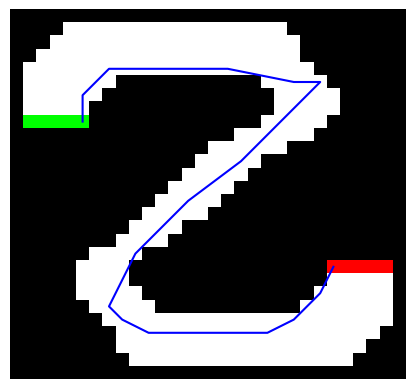

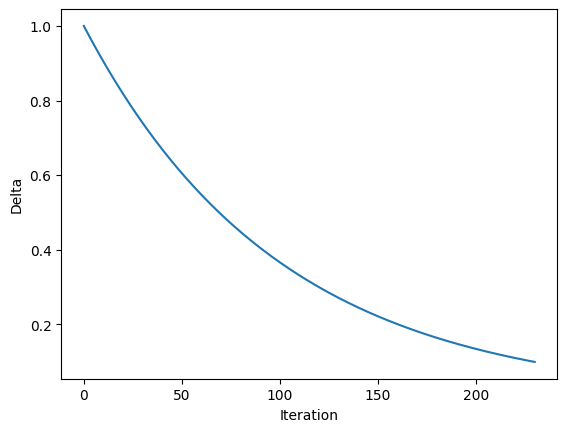

In [ ]:
import copy
import random
import numpy as np

# deterministic transition function (no randomness)
def transition(oldY, oldX, oldVY, oldVX, accel, racetrack):
    # apply acceleration
    newVX = oldVX + accel[0]
    newVY = oldVY + accel[1]

    # clamp velocities
    if newVX > 5:
        newVX = 5
    if newVX < -5:
        newVX = -5
    if newVY > 5:
        newVY = 5
    if newVY < -5:
        newVY = -5

    newX = oldX + newVX
    newY = oldY + newVY

    carCourse = bresenhamsAlgorithm(oldX, newX, oldY, newY)

    crashed = False
    finished = False
    nearestPoint = None
    finishPoint = None

    for i, pos in enumerate(carCourse):
        if pos in racetrack.walls:
            crashed = True
            # nearest safe point before crash
            nearestPoint = carCourse[max(0, i-1)]
            break
        if pos in racetrack.finishStates:
            finished = True
            finishPoint = pos

            break

    if crashed:
        if CRASH_POS == "NRST":
            # place at nearest point with zero velocity
            newX = nearestPoint[0]
            newY = nearestPoint[1]
        if CRASH_POS == "STRT":
            # Back to start
            start = random.choice(racetrack.startStates)
            newX = start[0]
            newY = start[1]
        newVX = 0
        newVY = 0

    if finished:
        newX = finishPoint[0]
        newY = finishPoint[1]
        newVX = 0
        newVY = 0

    # Ensure newX/newY are ints within array bounds
    cols = racetrack.size[0]
    rows = racetrack.size[1]
    if newX < 0: newX = 0
    if newX >= cols: newX = cols - 1
    if newY < 0: newY = 0
    if newY >= rows: newY = rows - 1

    return newY, newX, newVY, newVX, crashed, finished


def valueIteration(racetrack, error, discount):
    rows = racetrack.size[1]
    cols = racetrack.size[0]

    vel_list = list(range(-5, 6))            # [-5, -4, ... , 5]
    len_v = len(vel_list)
    v2i = {v: i for i, v in enumerate(vel_list)}
    i2v = {i: v for v, i in v2i.items()}

    actions = [(-1,-1), (0,-1), (1,-1),
               (-1,0) , (0,0),  (1,0),
               (-1,1) , (0,1),  (1,1)]
    len_a = len(actions)

    # values[y][x][vy_idx][vx_idx]
    values = [[[[0.0 for _ in range(len_v)]
                    for _ in range(len_v)]
                    for _ in range(cols)]
                    for _ in range(rows)]

    # initialize values (you previously used random; zeros are fine)
    for y in range(rows):
        for x in range(cols):
            for vi in range(len_v):
                for vj in range(len_v):
                    values[y][x][vi][vj] = 0.0

    # set terminal states to 0 explicitly (if any)
    for x in range(cols):
        for y in range(rows):
            if racetrack.array[x][y] in racetrack.finishStates:
                for vi in range(len_v):
                    for vj in range(len_v):
                        values[y][x][vi][vj] = 0.0

    # Q[y][x][vi][vj][ai]
    Q = [[[[[0.0 for _ in range(len_a)]
              for _ in range(len_v)]
              for _ in range(len_v)]
              for _ in range(cols)]
              for _ in range(rows)]
    
    T = {}

    for y in range(rows):   
        for x in range(cols):
            for vy in vel_list:
                for vx in vel_list:
                    for ai, a in enumerate(actions):
                        succ = transition(y, x, vy, vx, a, racetrack)
                        fail = transition(y, x, vy, vx, (0,0), racetrack)
                        T[(y,x,vy,vx,ai)] = (succ[:4], fail[:4])

    # main value iteration loop
    iteration = 0
    deltaList = []
    iterList = []
    while True:
        iteration += 1
        iterList.append(iteration)
        valuesPrev = copy.deepcopy(values)
        delta = 0.0

        for y in range(rows):
            for x in range(cols):
                # check if terminal cell
                is_terminal = ((x, y) in racetrack.finishStates)

                for vi in range(len_v):
                    for vj in range(len_v):
                        vy = i2v[vi]
                        vx = i2v[vj]

                        if is_terminal:
                            # terminal state's Q = 0 for all actions
                            for ai in range(len_a):
                                Q[y][x][vi][vj][ai] = 0.0
                            values[y][x][vi][vj] = 0.0
                            continue

                        # for each action compute expected value deterministically:
                        for ai, a in enumerate(actions):
                            r = -1
                            (sy, sx, svy, svx), (fy, fx, fvy, fvx) = T[(y,x,vy,vx,ai)]

                            # convert returned velocities to indices
                            vi_succ = v2i[svy]
                            vj_succ = v2i[svx]
                            vi_fail = v2i[fvy]
                            vj_fail = v2i[fvx]

                            val_succ = valuesPrev[sy][sx][vi_succ][vj_succ]
                            val_fail = valuesPrev[fy][fx][vi_fail][vj_fail]

                            expected = 0.80 * val_succ + 0.20 * val_fail
                            Q[y][x][vi][vj][ai] = r + discount * expected

                        # pick best action
                        best_ai = int(np.argmax(Q[y][x][vi][vj]))
                        new_value = Q[y][x][vi][vj][best_ai]
                        # update delta
                        diff = abs(new_value - valuesPrev[y][x][vi][vj])
                        if diff > delta:
                            delta = diff
                        
                        values[y][x][vi][vj] = new_value

        # keep terminals zero
        for x in range(cols):
            for y in range(rows):
                if (x,y) in racetrack.finishStates:
                    for vi in range(len_v):
                        for vj in range(len_v):
                            values[y][x][vi][vj] = 0.0
        deltaList.append(delta)
        if delta < error:
            break

    # build deterministic greedy policy mapping (state -> action)
    pi = {}
    for y in range(rows):
        for x in range(cols):
            for vi in range(len_v):
                for vj in range(len_v):
                    best_ai = int(np.argmax(Q[y][x][vi][vj]))
                    vy = i2v[vi]
                    vx = i2v[vj]
                    pi[(y, x, vy, vx)] = actions[best_ai]

    return pi,iteration


r = RaceTrack(TRACK_NAME)
c = Car(r)
x_coord = [c.xPos]
y_coord = [c.yPos]
graph = makePlot(r)
r.printTrack(c)
policy,iterations = valueIteration(r, 0.1, .99)

c.resetCar()
x_coord = [c.xPos]
y_coord = [c.yPos]
for i in range(200):
    actionChosen = policy[(c.yPos,c.xPos,c.yVel,c.xVel)]
    c.updatePos(actionChosen[0],actionChosen[1], False)
    x_coord.append(c.xPos)
    y_coord.append(c.yPos)
    carState = (c.xPos, c.yPos)
    if(carState in r.finishStates):
        break

print("Training iterations: ",iterations)
print("Steps taken: ",i)

graph = makePlot(r)
graph.plot(x_coord,y_coord,linestyle = '-', color = 'blue')
graph.show()


